### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # simple price plots
from tqdm.notebook import tqdm # show progress bar when downloading data

# crypto data
from binance.client import Client

# client configuration
apiKey = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
apiSecurity = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
client = Client(apiKey, apiSecurity)

### Download historical crypto data

In [18]:
def get_data(pair, interval = '1d', start_date = '2021-01-01'):
    try:
        # Kline stands for Candlesticks data
        Client.KLINE_INTERVAL_30MINUTE
        # fetch 30 minute klines for selected pair
        klines = client.get_historical_klines(pair, interval, start_date)
        
        # convert data to pandas DataFrame
        data = pd.DataFrame(klines)
        # drop columns that we don't need
        data.drop([6, 7, 8, 9, 10, 11], axis = 1, inplace = True)
        # rename columns
        data.columns=['datetime', 'Open', 'High', 'Low', 'Close', 'Volume']
        # convert data to float (Binance returns them as as string)
        data = data.astype(float)
        # convert datetime column to readable format
        data['datetime'] = pd.to_datetime(pd.to_datetime(data['datetime'], unit = 'ms', utc = True).dt.tz_convert('Europe/Dublin').dt.strftime('%Y-%m-%d %H:%M:%S'))
        # set datetime column as an index
        data.set_index('datetime', drop = True, inplace=True)
        return data
    
    except Exception as e:
        print(e)

In [19]:
get_data('BTCUSDT')

,Open,High,Low,Close,Volume
datetime,,,,,
2021-01-01,28923.63,29600.00,28624.57,29331.69,54182.925011
2021-01-02,29331.70,33300.00,28946.53,32178.33,129993.873362
2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.566750
2021-01-04,33000.05,33600.00,28130.00,31988.71,140899.885690
2021-01-05,31989.75,34360.00,29900.00,33949.53,116049.997038
...,...,...,...,...,...
2023-01-08,16943.83,17176.99,16911.00,17127.83,135155.896950
2023-01-09,17127.83,17398.80,17104.66,17178.26,266211.527230
2023-01-10,17179.04,17499.00,17146.34,17440.66,221382.425810


### Get list of all crypto pairs

In [20]:
# download exchange info data in json format
symbols = client.get_exchange_info()
# convert it to pandas DataFrame
df = pd.DataFrame(symbols['symbols'])

# empty list where we store crypto pairs
pairs_list = []

# itterate through the rows and append pairs that meet our requirements
for index, data in df.iterrows():
    # save only pairs with Margin trading allowed and USDT as second pair
    if data['isMarginTradingAllowed'] == True and data['symbol'][-4:] == 'USDT':
        pairs_list.append(data['symbol'])

In [21]:
# print first few pairs as an example
print(pairs_list[:10])

['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'NEOUSDT', 'LTCUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'IOTAUSDT']


### Download data for all pairs in saved list

I want to have all data in one big DataFrame where each column represents 1 Crypto pair with each row as a price for selected interval.

In [22]:
# create empty dictionary where we store downloaded data as a value with pair name as a key
price_data = {}

# itterate through the list we saved above (use the tqdm to see progress bar)
for pair in tqdm(pairs_list):
    data = get_data(pair)
    # skip this itterateion if we don't get any data back
    if isinstance(data, type(None)):
        pass
        print('skipped data', pair)
    else:
        # if we get data back, save it to dictionary
        price_data[pair] = data['Close']
        
# convert dictionary to pandas DataFrame
data_df = pd.DataFrame.from_dict(price_data)
data_df.head()

  0%|          | 0/220 [00:00<?, ?it/s]

,BTCUSDT,ETHUSDT,BNBUSDT,NEOUSDT,LTCUSDT,QTUMUSDT,ADAUSDT,XRPUSDT,EOSUSDT,IOTAUSDT,...,LDOUSDT,EPXUSDT,OPUSDT,LEVERUSDT,STGUSDT,LUNCUSDT,GMXUSDT,POLYXUSDT,APTUSDT,OSMOUSDT
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01,29331.69,728.91,37.7762,14.461,126.24,2.268,0.17509,0.23746,2.6378,0.2912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,32178.33,774.56,38.2331,14.426,136.96,2.249,0.17742,0.22064,2.6321,0.2863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03,33000.05,978.28,41.2575,16.024,161.24,2.466,0.20615,0.22540,2.7985,0.3098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-04,31988.71,1041.43,41.1333,16.372,155.34,2.515,0.22528,0.23565,2.8191,0.3433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,33949.53,1099.56,41.8219,16.868,158.43,2.612,0.25873,0.22573,2.8862,0.3520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot closing prices

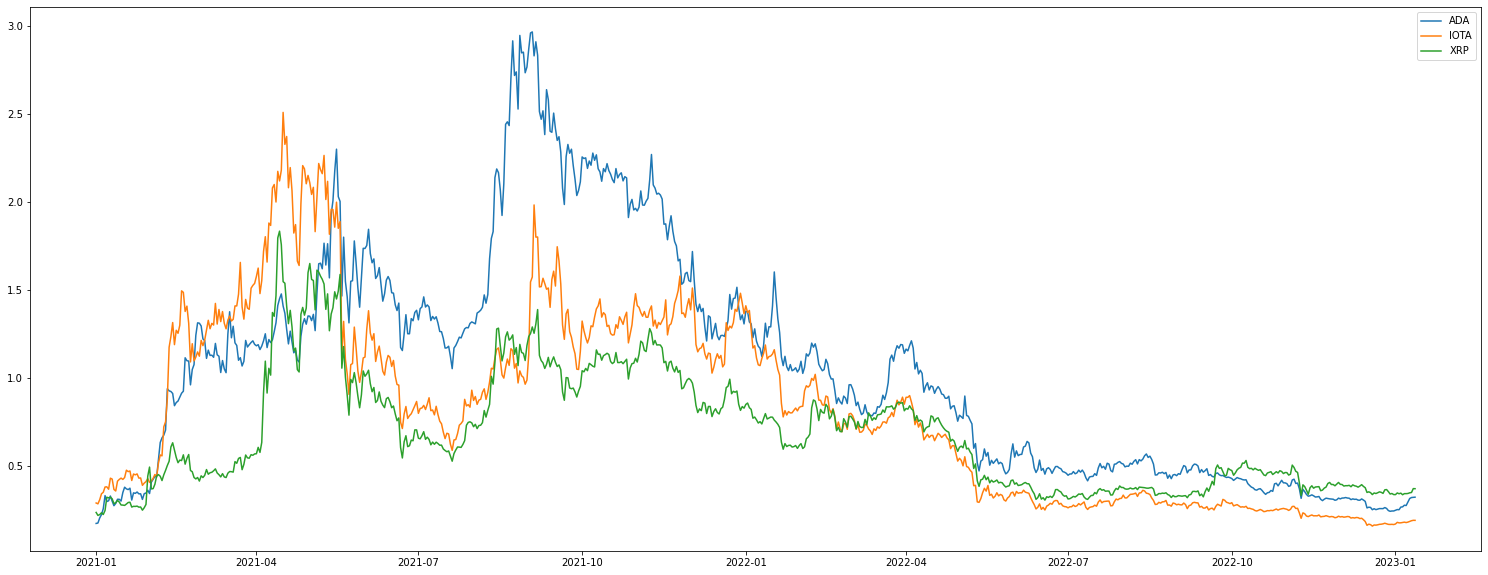

In [38]:
# change the size of plot
plt.figure(figsize = (26, 10))
plt.plot(data_df['ADAUSDT'], label = 'ADA')
plt.plot(data_df['IOTAUSDT'], label = 'IOTA')
plt.plot(data_df['XRPUSDT'], label = 'XRP')
plt.legend()
plt.show()